# Utility Results

In [1]:
from functools import reduce
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('../src')
import raybay
from utils import get_util_df, get_percent_diff

## Full 100 Iterations

In [2]:
full_df = pd.concat([get_util_df(plan_type) for plan_type in ['clinical', 'default', 'random', 'bayes']])
full_df.groupby('plan_type').describe()

plan_util                                                    \
              count        mean          std          min         25%   
plan_type                                                               
bayes          10.0  412.684219   106.685630   185.052909  355.168655   
clinical       10.0 -769.232355  2803.424147 -8630.470766 -398.060321   
default        10.0 -419.295109   506.428862 -1222.213527 -706.553129   
random         10.0  396.072994   115.239690   159.011493  334.429651   

                                               
                  50%         75%         max  
plan_type                                      
bayes      424.947532  490.793878  537.678328  
clinical   273.066535  383.139593  466.324841  
default   -318.226430   -0.697789  155.170588  
random     425.428612  473.447650  533.831554

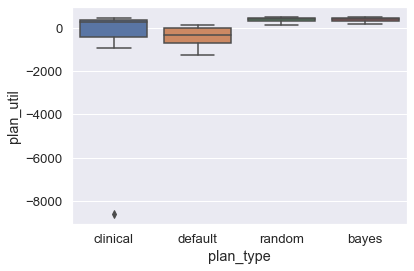

In [3]:
sns.boxplot(x='plan_type', y='plan_util', data=full_df);

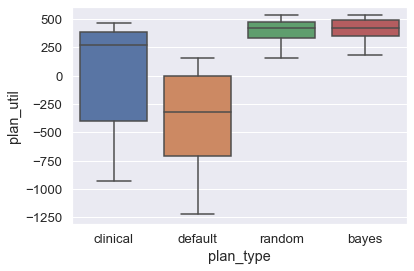

In [4]:
ax = sns.boxplot(x='plan_type', y='plan_util', data=full_df)
ax.set_ylim([-1310, 610]);

### Compare plan utilities

In [5]:
def get_util_diff(row):
    return get_percent_diff(row, 'plan_util_x', 'plan_util_y')

def get_compare(plan, ref):
    df = pd.merge(
        get_util_df(plan),
        get_util_df(ref),
        on='patient')
    df['compare_type'] = plan + '2' + ref
    df['percent_diff'] = df.apply(get_util_diff, axis=1)
    return df[['patient', 'compare_type', 'percent_diff']]

pair_list = [['random', 'clinical'], ['bayes', 'clinical'], ['bayes', 'random']]
compare_df = pd.concat([get_compare(*pair) for pair in pair_list]).reset_index(drop=True)
compare_df.groupby('compare_type').describe()

percent_diff                                              \
                       count       mean        std        min        25%   
compare_type                                                               
bayes2clinical          10.0  50.449900  64.174188 -24.172086  12.183501   
bayes2random            10.0   5.673105   7.630559  -2.500267   2.289448   
random2clinical         10.0  45.158680  67.421217 -34.842906   9.597440   

                                                   
                       50%        75%         max  
compare_type                                       
bayes2clinical   21.525633  89.786249  167.482992  
bayes2random      3.085595   4.827368   22.357366  
random2clinical  12.770888  85.887661  169.213515

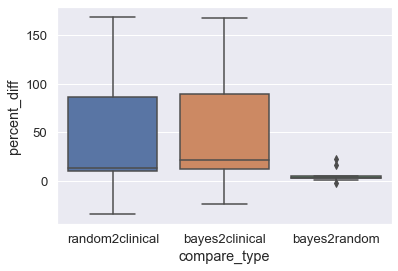

In [6]:
sns.boxplot(x='compare_type', y='percent_diff', data=compare_df);

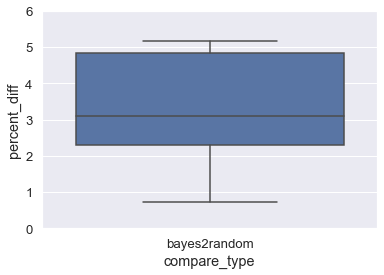

In [7]:
ax = sns.boxplot(x='compare_type', y='percent_diff', data=compare_df[compare_df['compare_type'] == 'bayes2random']);
ax.set_ylim([0, 6]);

## With Stopping Conditions

In [8]:
stop_df = pd.concat([get_util_df(plan_type, stop=True) for plan_type in ['clinical', 'default', 'random', 'bayes']])
stop_df.groupby('plan_type').describe()

plan_util                                                    \
              count        mean          std          min         25%   
plan_type                                                               
bayes          10.0  349.917443   190.221888   -55.831139  327.430313   
clinical       10.0 -769.232355  2803.424147 -8630.470766 -398.060321   
default        10.0 -419.295109   506.428862 -1222.213527 -706.553129   
random         10.0  223.748258   453.013900  -939.482752  301.643429   

                                               
                  50%         75%         max  
plan_type                                      
bayes      396.885683  471.837543  533.831554  
clinical   273.066535  383.139593  466.324841  
default   -318.226430   -0.697789  155.170588  
random     389.435587  457.094320  533.831554

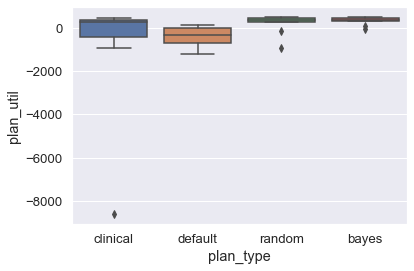

In [9]:
sns.boxplot(x='plan_type', y='plan_util', data=stop_df);

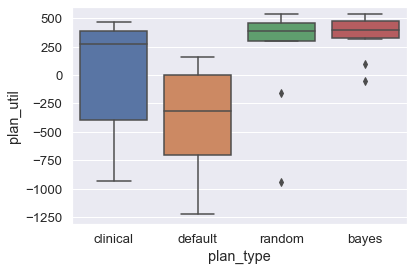

In [10]:
ax = sns.boxplot(x='plan_type', y='plan_util', data=stop_df)
ax.set_ylim([-1310, 600]);

### Compare to 100 iterations

In [11]:
def get_util_diff(row):
    return get_percent_diff(row, 'plan_util_stop', 'plan_util_full')

compare_df = pd.merge(
    full_df,
    stop_df,
    on=['patient', 'plan_type'],
    suffixes=['_full', '_stop']
)
compare_df = compare_df[compare_df['plan_type'].isin(['random', 'bayes'])]
compare_df['percent_diff'] = compare_df.apply(get_util_diff, axis=1)
compare_df.groupby('plan_type')['percent_diff'].describe()

,count,mean,std,min,25%,50%,75%,max
plan_type,,,,,,,,
bayes,10.0,-23.361356,43.588153,-130.170366,-9.919642,-3.867651,-1.450736,0.0
random,10.0,-89.107486,216.594888,-690.826948,-14.567184,-5.307210,-3.146759,0.0


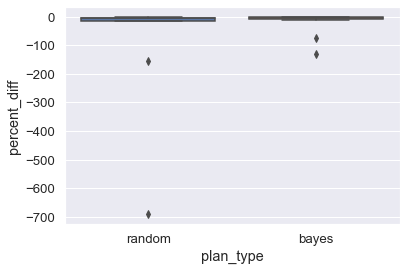

In [12]:
sns.boxplot(x='plan_type', y='percent_diff', data=compare_df);

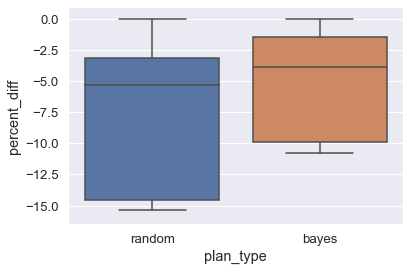

In [13]:
ax = sns.boxplot(x='plan_type', y='percent_diff', data=compare_df)
ax.set_ylim([-16.5, 1]);